In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
#drive.flush_and_unmount(timeout_ms=24)

In [ ]:
!unzip /content/dataset-resized.zip -d dataset-resized

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
import os 
import keras
from keras.preprocessing.image import load_img, smart_resize
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Activation, Dropout, DepthwiseConv2D, MaxPool2D
import tensorflow as tf
from tensorflow.keras import layers

In [8]:
# General data parameters

DATASET_PATH = 'dataset-resized'
SHUFFLE_DATA = True

# Data generator parameters
TRAINING_BATCH_SIZE = 128
TRAINING_IMAGE_SIZE = (256, 256)
VALIDATION_BATCH_SIZE = 128
VALIDATION_IMAGE_SIZE = (256, 256)
VALIDATION_DATASET_SIZE = 324
TESTING_BATCH_SIZE = 16
TESTING_IMAGE_SIZE = (256, 256)
TEST_DATASET_SIZE = 324
NUMBER_OF_CHANNELS = 3
TRANSFORM = True


# Model parameters
NBNEURONE1 = 128
NBNEURONE2 = 6
taux_apprentissage = 0.001
NBEPOCH = 200
descenteGrade = Adam(taux_apprentissage)

# Values for metric
WORK_PER_PERSON_FOR_TWENTY_MINS = 80.54
MARGIN = 9

In [14]:

def create_generators(data_path=DATASET_PATH):
    'Returns three generators'
    image_paths = []
    for folder in os.listdir(data_path):
        paths_to_add = [os.path.join(folder, path) for path in os.listdir(os.path.join(data_path, folder)) if path.endswith('jpg')]
        image_paths = image_paths + paths_to_add

    train_list, val_list, test_list = data_split(np.asarray(image_paths))

    train_data_generator = DataGeneratorClassifier(train_list, TRAINING_BATCH_SIZE, TRAINING_IMAGE_SIZE)
    validation_data_generator = DataGeneratorClassifier(val_list, VALIDATION_BATCH_SIZE, VALIDATION_IMAGE_SIZE, transform=False)
    test_data_generator = DataGeneratorClassifier(test_list, TESTING_BATCH_SIZE, TESTING_IMAGE_SIZE, transform=False)
    return train_data_generator, validation_data_generator, test_data_generator


def data_split(paths_list):
    'Splits the paths list into three splits'
    np.random.seed(0)
    np.random.shuffle(paths_list)
    return paths_list[TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE:], paths_list[TEST_DATASET_SIZE:TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE], paths_list[:TEST_DATASET_SIZE]




class DataGeneratorClassifier(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size, image_size, data_path=DATASET_PATH, n_channels=NUMBER_OF_CHANNELS, shuffle=SHUFFLE_DATA, transform=TRANSFORM):
        'Initialisation'
        self.classes = os.listdir(data_path)
        self.image_size = image_size
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data_path=data_path
        self.transform=transform

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.list_IDs[indexes]
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *image_size, n_channels)
        X = np.empty((self.batch_size, *self.image_size, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            
            Xi = load_img(os.path.join(self.data_path, ID))
            Xi = smart_resize(np.asarray(Xi), self.image_size)
            X[i,:] = Xi

            y[i] = self.classes.index(ID.split('/')[0])
        if self.transform:
            data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            layers.experimental.preprocessing.RandomRotation(0.8)])
            X=data_augmentation(X)

        return X,keras.utils.to_categorical(y,num_classes=6)

def show_batch(generator, batch_number=0):
    images, labels = generator.__getitem__(batch_number)
    width = int(np.floor(np.sqrt(labels.shape[0])))
    height = int(np.ceil(labels.shape[0]/float(width)))
    total_height = int(0.09*height*images.shape[1])
    total_width = int(0.09*width*images.shape[2])
    f, axarr = plt.subplots(height,width, figsize=(total_height,total_width))
    for image in range(images.shape[0]):
        image_to_show = (images[image])/np.max(images[image])
        axarr[image//width,image%width].imshow(image_to_show)
        axarr[image//width,image%width].set_title(generator.classes[np.argmax(labels[image])])
    f.tight_layout()
    plt.show()

In [ ]:
def training(generatorTrain, generatorVal,descenteGrade):
    model=create_model()
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=descenteGrade, 
        metrics=['accuracy'] # métrique à changer  workforce_needed_create(1879), my_metric_fn

    )
    # metric_train = []
    # metric_validation = []
    # for epoch in range(NBEPOCH):
    history=model.fit_generator(
    generatorTrain, epochs=NBEPOCH, callbacks=None,
    validation_data=generatorVal,
    class_weight=None,shuffle= SHUFFLE_DATA)
        #list_temp=generatorVal.indexes
        #ytrue= generatorVal.__data_generation(list_temp) #ici
        #ypred=model.predict_generator(generatorVal)
        #print(np.sum(ytrue==ypred)/66)
        # metric_train.append(workforce_needed(generatorTrain, model, phase='train'))
        # metric_validation.append(workforce_needed(generatorVal, model, phase='validation'))
        # plt.plot(metric_train, label='Metric on training')
        # plt.plot(metric_validation, label='Metric on validation')
        # plt.legend()
        # plt.show()
        

        
    model.save('checkpoint')
    return model,history


In [ ]:
def confusion_matrix(x_test, y_test, model):
    
    M = np.zeros((6, 6))
    L = model.predict_classes(x_test)
    for i in range(len(y_test)):
        k = 0
        for j in range (1,6):
            k = j*y_test[i][j]
        M[L[i]][k] += 1
    return M.astype(int)


# def show_confusion_matrix(confusion_matrix):
#     for i in range(6):
#         print(confusion_matrix[i])
#     plt.imshow(confusion_matrix)
#     plt.colorbar()
#     plt.title('Matrice de confusion data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])sur la base de données de test')
#     plt.xlabel('Classe réelle')
#     plt.ylabel('Classe prévue par le réseau')
#     plt.show()


def workforce_needed(generator, model, phase='train'):
    if phase == 'train':
        dataset_size = 2527 - VALIDATION_DATASET_SIZE - TEST_DATASET_SIZE
        batch_size = TRAINING_BATCH_SIZE
    elif phase == 'test':
        dataset_size = TEST_DATASET_SIZE
        batch_size = TESTING_BATCH_SIZE
    elif phase == 'validation':
        dataset_size = VALIDATION_DATASET_SIZE
        batch_size = VALIDATION_BATCH_SIZE
    number_of_batches = dataset_size//batch_size
    y_true = []
    y_pred = []
    for batch_number in range(number_of_batches):
        images, labels = generator.__getitem__(batch_number)
        y_true.append(labels)
        y_pred_to_add = model.predict(images)
        y_pred.append(y_pred_to_add)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    nombre_dechets = y_true.shape[0]
    rapport_temps = nombre_dechets / 2527
    work_per_person = WORK_PER_PERSON_FOR_TWENTY_MINS * rapport_temps
    nombre_dechets_mal_tries = [0 for i in range(6)]
    for j in range(nombre_dechets):
        if (y_true[j] != y_pred[j]).all() :
            numero_ligne = 0
            for i in range(6):
                numero_ligne += y_pred[j][i]*i
            nombre_dechets_mal_tries[int(numero_ligne)] += 1
    workforce = [nombre_dechets_mal_tries[i]/work_per_person for i in range(6)]
    return workforce


def workforce_needed_create(dataset_size) :  # return a function
    def  workforce_needed(y_true,y_pred):   #y_true shape =(1,6)  
        work = [0 for i in range(6)]
        # y_pred_decision = tf.argmax(y_pred)
        # y_true_decision = tf.argmax(y_true)
        # if y_true_decision != y_pred_decision :
        #   work[int(y_pred_decision.numpy())] = 1
        return [1, 0]
    return workforce_needed

def my_metric_fn(y_true, y_pred):
  y_true_dec = tf.argmax(y_true,1)
  y_pred_dec = tf.argmax(y_pred,1)
  classe = tf.argmax(y_true)
  print("\nclasse")
  print(classe)
  zeros = y_true_dec * 0
  print("zeros")
  print(zeros)
  print("y_true")
  print(y_true_dec)
  # a = (y_pred_dec != y_true_dec) and (y_pred_dec == zeros)
  a = (y_pred_dec != y_true_dec)
  return a

In [ ]:
tf.constant([0])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

In [10]:
def create_model():
    tf.random.set_seed(1234)

    model = Sequential()
    #https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D

    model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    model.add(Conv2D(64, (1,1), activation="relu", strides=(1,1), padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    model.add(Conv2D(128, (1,1), activation="relu", strides=(1,1), padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    model.add(Conv2D(256, (1,1), activation="relu", strides=(1,1), padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    model.add(Conv2D(256, (1,1), activation="relu", strides=(1,1), padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    model.add(Conv2D(256, (1,1), activation="relu", strides=(1,1), padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # model.add(DepthwiseConv2D((3,3),activation="relu", strides=(1,1), padding = "same", input_shape=(TRAINING_IMAGE_SIZE[0],TRAINING_IMAGE_SIZE[0],NUMBER_OF_CHANNELS)))
    # model.add(Conv2D(256, (1,1), activation="relu", strides=(1,1), padding = "same"))
    # model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256,activation="relu"))
    #model.add(Dropout(0.4))

    model.add(Dense(128,activation="relu"))
    #model.add(Dropout(0.4))

    model.add(Dense(128,activation="relu"))
    #model.add(Dropout(0.4))

    model.add(Dense(64,activation="relu"))
    #model.add(Dropout(0.4))

    model.add(Dense(6,activation="softmax"))
    model.summary()

    return model

In [ ]:
trainGenerator,valGenerator,testGenerator=create_generators()

In [11]:
model,history=training(trainGenerator,valGenerator,descenteGrade)

NameError: ignored

# Nouvelle section

20/20 [==============================] - 4s 162ms/step - loss: 1.4073 - accuracy: 0.7812
Erreur de la base de données TEST 1.4072942733764648
Taux de reconnaisance 0.78125


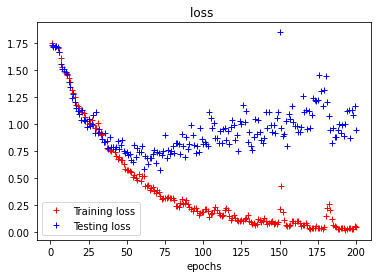

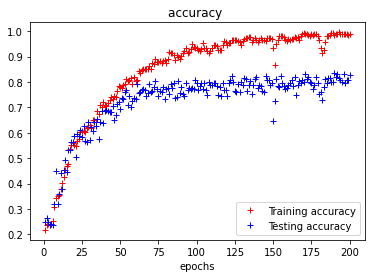

In [ ]:
loss_and_metrics=model.evaluate(testGenerator, batch_size=324)

epochs=range(1,NBEPOCH+1)

loss_train=history.history["loss"]
metrics_train=history.history["accuracy"]

loss_test=history.history["val_loss"]
metrics_test=history.history["val_accuracy"]


print('Erreur de la base de données TEST',loss_and_metrics[0])
print('Taux de reconnaisance',loss_and_metrics[1])
plt.figure()
plt.title("loss ")
plt.plot(epochs,loss_train,'r+',label="Training loss")
plt.plot(epochs,loss_test,'b+',label="Testing loss")
plt.legend()
plt.xlabel("epochs")
plt.show()

plt.figure()
plt.title("accuracy ")
plt.plot(epochs,metrics_train,'r+',label="Training accuracy")
plt.plot(epochs,metrics_test,'b+',label="Testing accuracy")
plt.legend()
plt.xlabel("epochs")
plt.show()
